In [2]:
!pip install --upgrade "typeguard>=4.1.2,<5"

!pip install -U tensorflow-addons


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import os

In [4]:
DATASET_DIR = '../input/eggplant-disease-recognition-dataset/Eggplant Disease Recognition Dataset/Augmented Images (Version 02)/Augmented Images (Version 02)/'
ALL_IMAGES = []
EQU_IMAGES = []
LABELS = []

In [5]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_COLOR = 3

In [6]:
classes = os.listdir(DATASET_DIR)
classes_reshape = np.array(classes).reshape(-1, 1)

In [7]:
classes_nums = [indx for indx, val in enumerate(classes_reshape)]
classes_nums

[0, 1, 2, 3, 4, 5, 6]

In [8]:
def data_preparation(path_, classes_):
    images = []
    labels = []
    i=0
    for class_ in classes_:
        print(class_)
        print(i)
        for filename in os.listdir(path_+class_):
            path = path_+class_+'/'+filename
            img = cv2.imread(path)
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
            images.append(img)
            labels.append(i)
        i+=1
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [9]:
def image_equalization(images_):
    result = []
    for image in images_:
        R, G, B = cv2.split(image)
        output1_R = cv2.equalizeHist(R)
        output1_G = cv2.equalizeHist(G)
        output1_B = cv2.equalizeHist(B)
        equ = cv2.merge((output1_R, output1_G, output1_B))
        result.append(equ)
    result = np.array(result)    
    return result

In [10]:
def plot_two_images(img1, img2):
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img1)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img2)
    plt.show()

In [11]:
def show_images(images, predicted_classes, actual_classes, test_nums):
    rows = int(np.ceil(np.sqrt(len(test_nums))))
    cols = int(np.ceil(len(test_nums) / rows))
    f, axes = plt.subplots(rows, cols, figsize=(20, 6))
    k = 0
    axes = axes.ravel()
    for image in range(0, len(test_nums)):
        f.tight_layout()
        f.subplots_adjust(top=0.92)
        axe = axes[k]
        test_num = test_nums[k]
        predicted_class = get_class(predicted_classes[test_num])
        actual_class = get_class(np.argmax(actual_classes[test_num]))
        title = "\n".join(wrap('Actual Class: ' + str(actual_class)+',   Predicted Class: ' + str(predicted_class)))
        axe.set_title(title)
        axe.axis('off')
        axe.imshow(images[test_num], cmap='gray')
        k+=1
    plt.show()

In [12]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])

In [13]:
ALL_IMAGES, LABELS = data_preparation(DATASET_DIR, classes)
EQU_IMAGES = image_equalization(ALL_IMAGES)
print('Number of images: ', len(ALL_IMAGES))
print('Nubmer of labels: ', len(LABELS))

Augmented Wilt Disease
0
Augmented Small Leaf Disease
1
Augmented Healthy Leaf
2
Augmented Insect Pest Disease
3
Augmented Mosaic Virus Disease
4
Augmented Leaf Spot Disease
5
Augmented White Mold Disease
6
Number of images:  9800
Nubmer of labels:  9800


**Savinf Figures**

In [14]:
import os
import matplotlib.pyplot as plt

# Set the path for the directory where you want to save the images
IMAGES_PATH = "/kaggle/working/"

# Define a function to save the figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=600):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure Eggplant_Image Processing


<Figure size 640x480 with 0 Axes>

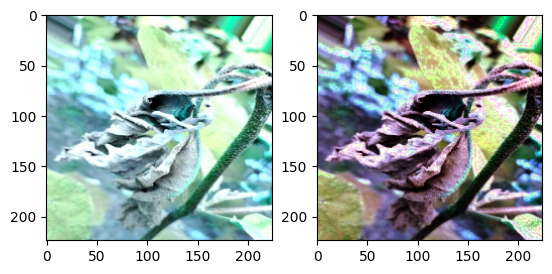

In [15]:
save_fig("Eggplant_Image Processing")
plot_two_images(ALL_IMAGES[0], EQU_IMAGES[0])

In [27]:
# IGNORE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

def hot_encoder(labels):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [28]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def hot_encoder(labels):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    onehot_encoded = to_categorical(integer_encoded)
    return onehot_encoded


In [29]:
onehot_encoded = hot_encoder(LABELS)
X, y = EQU_IMAGES, onehot_encoded

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7644, 224, 224, 3) (7644, 7)
(2156, 224, 224, 3) (2156, 7)


In [31]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)

# Split the train set further into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes of the datasets
print("Train data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)


Train data shape: (6115, 224, 224, 3) (6115, 7)
Validation data shape: (1529, 224, 224, 3) (1529, 7)
Test data shape: (2156, 224, 224, 3) (2156, 7)


In [32]:
def get_class(y):
    _class = ''
    if y == 0: _class = 'Wilt Disease'
    if y == 1: _class = 'Small Leaf Disease'
    if y == 2: _class = 'Healthy Leaf'
    if y == 3: _class = 'Insect Pest Disease'
    if y == 4: _class = 'Mosaic Virus Disease'
    if y == 5: _class = 'Leaf Spot Disease'
    if y == 6: _class = 'White Mold Disease'
    return _class

# **CNN**

**Model**

In [21]:
import numpy as np
import matplotlib.pyplot as plt


# Define a more complex CNN model with dropout regularization
cnn_model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu'),
    
    layers.Dense(7, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

**Model Train**

In [22]:
#CODE FOR Validation Loss

import numpy as np
import matplotlib.pyplot as plt

# ... Rest of your code ...

# Define a more complex CNN model with dropout regularization
cnn_model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu'),
    
    layers.Dense(7, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

cnn_model.summary()

# Use validation_data parameter to provide validation data for each epoch
cnn_history = cnn_model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

**Training and Validation Loss**

Saving figure Eggplant_Training and Validation Loss_CNN


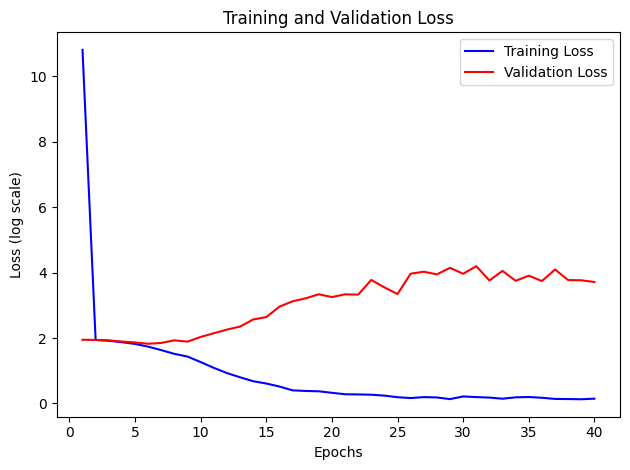

In [23]:
# Access the training and validation loss values from the history object
train_loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

# Plot the training and validation loss curves with a logarithmic scale for the Y-axis
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
save_fig("Eggplant_Training and Validation Loss_CNN")
plt.show()


**Training and Validation Accuracy**

Saving figure Eggplant_Training and Validation Accuracy_CNN


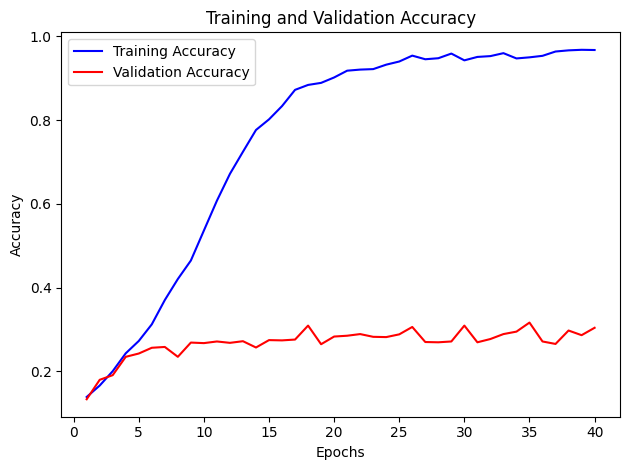

In [24]:
# Access the training and validation accuracy values from the history object
train_acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']

# Plot the training and validation accuracy curves
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
save_fig("Eggplant_Training and Validation Accuracy_CNN")
plt.show()

**Classification Report**

In [26]:
from sklearn.metrics import classification_report
cnn_acc = cnn_model.evaluate(X_test, y_test)[1]
print('CNN model accuracy:', cnn_acc*100)
y_pred = cnn_model.predict(X_test)
y_classes = [np.argmax(element) for element in y_pred]

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
class_report = classification_report(y_true_labels, y_classes, target_names=['Wilt Disease', 'Small Leaf Disease', 'Healthy Leaf', 'Insect Pest Disease', 'Mosaic Virus Disease', 'Leaf Spot Disease','White Mold Disease'])
print(class_report)

68/68 [==============================] - 20s 300ms/step - loss: 3.7229 - accuracy: 0.2955
CNN model accuracy: 29.545453190803528
68/68 [==============================] - 20s 298ms/step
                      precision    recall  f1-score   support

        Wilt Disease       0.43      0.50      0.46       315
  Small Leaf Disease       0.30      0.29      0.30       302
        Healthy Leaf       0.32      0.34      0.33       299
 Insect Pest Disease       0.25      0.19      0.22       332
Mosaic Virus Disease       0.24      0.28      0.26       297
   Leaf Spot Disease       0.23      0.21      0.22       307
  White Mold Disease       0.26      0.26      0.26       304

            accuracy                           0.30      2156
           macro avg       0.29      0.30      0.29      2156
        weighted avg       0.29      0.30      0.29      2156



Test accuracy

In [27]:
cnn_acc = cnn_model.evaluate(X_test, y_test)[1]
print('CNN TEST accuracy:', cnn_acc*100)

68/68 [==============================] - 20s 294ms/step - loss: 3.7229 - accuracy: 0.2955
CNN TEST accuracy: 29.545453190803528


**Confusion Matrix**

In [28]:
y_pred = cnn_model.predict(X_test)
y_classes = [np.argmax(element) for element in y_pred]

68/68 [==============================] - 20s 294ms/step


68/68 [==============================] - 20s 292ms/step
Saving figure CM_CNN


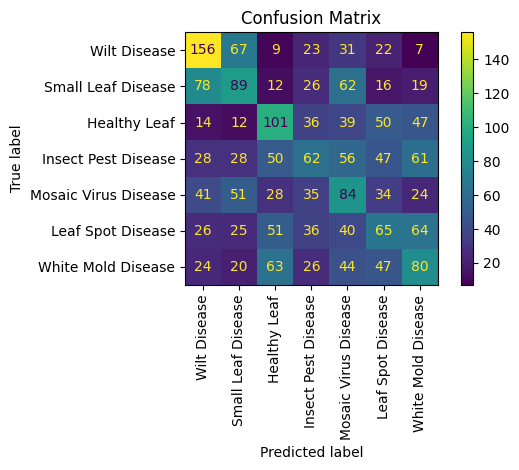

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test set and get predictions
y_pred = cnn_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wilt Disease', 'Small Leaf Disease', 'Healthy Leaf', 'Insect Pest Disease', 'Mosaic Virus Disease', 'Leaf Spot Disease','White Mold Disease'])
disp.plot(cmap='viridis', values_format='d')
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
save_fig("CM_CNN")
plt.show()


**Predicting Images**

Saving figure Result_CNN


<Figure size 640x480 with 0 Axes>

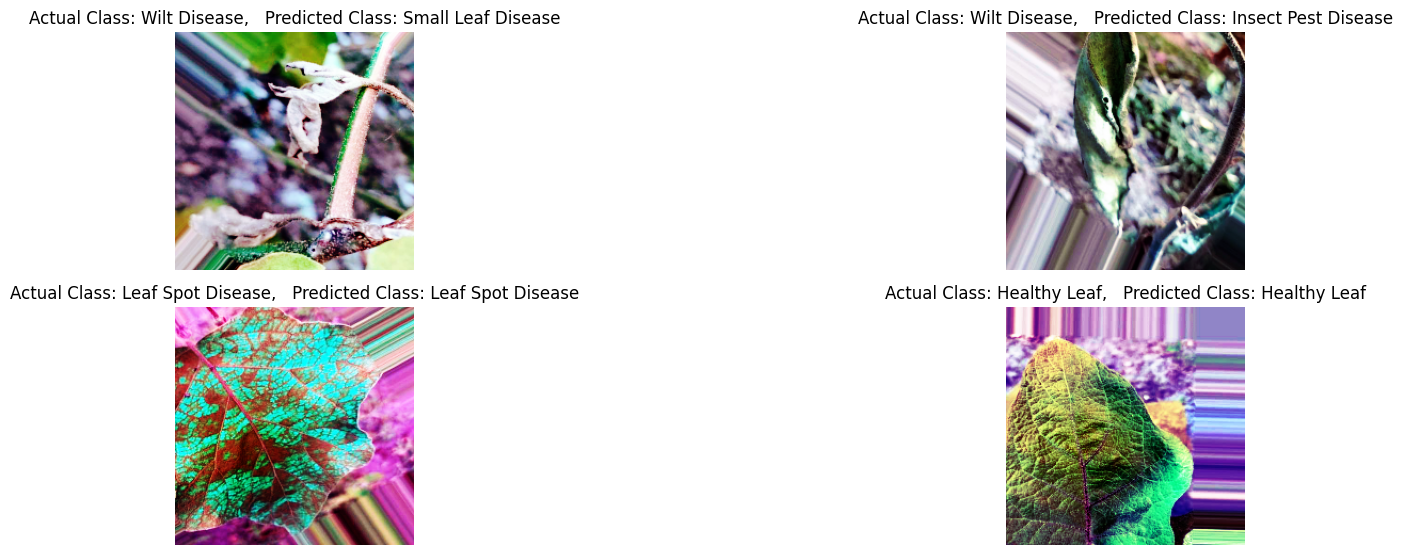

In [30]:
save_fig("Result_CNN")
show_images(images=X_test, actual_classes=y_test, predicted_classes=y_classes, test_nums=[1, 40, 100, 70]) # Test Cases: 1, 40, 100, 70

# DenseNET121

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor the validation set loss
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    verbose=1,          # To log the number of epoch after which training was stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored metric.
)


In [34]:
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR))
outputs = DenseNet121(include_top=True, weights=None, classes=len(classes))(inputs)
dense_net_model = tf.keras.Model(inputs, outputs)

dense_net_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

2024-02-20 14:03:22.341543: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-20 14:03:22.341658: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-20 14:03:22.341743: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-20 14:03:22.341841: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-20 14:03:22.341921: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-20 14:03:22.342141: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-20 14:03:22.342241: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

In [35]:
dense_net_hist = dense_net_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/25


NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/usr/local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_13/650744255.py", line 1, in <module>

  File "/usr/local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_78431]

In [ ]:
dense_net_model.summary()

**Training and Validation loss**

In [ ]:
# Access the training and validation loss values from the history object
train_loss = dense_net_hist.history['loss']
val_loss = dense_net_hist.history['val_loss']

# Plot the training and validation loss curves with a logarithmic scale for the Y-axis
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
save_fig("Eggplant_Training and Validation Loss_DenseNET121")
plt.show()


**Training and Validation Accuracy**

In [ ]:
# Access the training and validation accuracy values from the history object
train_acc = dense_net_hist.history['accuracy']
val_acc = dense_net_hist.history['val_accuracy']

# Plot the training and validation accuracy curves
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
save_fig("Eggplant_Training and Validation Accuracy_DenseNET121")
plt.show()

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
densenet_acc = dense_net_model.evaluate(X_test, y_test)[1]
print('DenseNET121 model accuracy:', densenet_acc*100)
y_pred = dense_net_model.predict(X_test)
y_classes = [np.argmax(element) for element in y_pred]

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
class_report = classification_report(y_true_labels, y_classes, target_names=['Wilt Disease', 'Small Leaf Disease', 'Healthy Leaf', 'Insect Pest Disease', 'Mosaic Virus Disease', 'Leaf Spot Disease','White Mold Disease'])
print(class_report)

**Test Accuracy**

In [ ]:
densenet_acc = dense_net_model.evaluate(X_test, y_test)[1]
print('DenseNET TEST accuracy:', densenet_acc*100)

**Confusion Matrix**

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test set and get predictions
y_pred = dense_net_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wilt Disease', 'Small Leaf Disease', 'Healthy Leaf', 'Insect Pest Disease', 'Mosaic Virus Disease', 'Leaf Spot Disease','White Mold Disease'])
disp.plot(cmap='viridis', values_format='d')
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
save_fig("CM_DenseNET")
plt.show()


**Predicting Images**

In [ ]:
save_fig("Result_DenseNET")
show_images(images=X_test, actual_classes=y_test, predicted_classes=y_classes, test_nums=[1, 40, 100, 70]) # Test Cases: 1, 40, 100, 70

# EfficientNET

**Early Stopping**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor the validation set loss
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    verbose=1,          # To log the number of epoch after which training was stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored metric.
)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

# Rest of your code...

inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR))
outputs = EfficientNetB0(include_top=True, weights=None, classes=len(classes))(inputs)
efficient_net_model = tf.keras.Model(inputs, outputs)

efficient_net_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])




**Model Run**

In [ ]:
# Use validation_data parameter to provide validation data for each epoch
efficient_net_hist = efficient_net_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

In [ ]:
efficient_net_model.summary()

**Training and Validation Loss**

In [ ]:
# Access the training and validation loss values from the history object
train_loss = efficient_net_hist.history['loss']
val_loss = efficient_net_hist.history['val_loss']

# Plot the training and validation loss curves with a logarithmic scale for the Y-axis
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
save_fig("Eggplant_Training and Validation Loss_EfficientNET")
plt.show()


**Training and Validation Accuracy**

In [ ]:
# Access the training and validation accuracy values from the history object
train_acc = efficient_net_hist.history['accuracy']
val_acc = efficient_net_hist.history['val_accuracy']

# Plot the training and validation accuracy curves
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
save_fig("Eggplant_Training and Validation Accuracy_EfficientNET")
plt.show()

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
efficient_acc = efficient_net_model.evaluate(X_test, y_test)[1]
print('EfficientNET model accuracy:', efficient_acc*100)
y_pred = efficient_net_model.predict(X_test)
y_classes = [np.argmax(element) for element in y_pred]

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
class_report = classification_report(y_true_labels, y_classes, target_names=['Wilt Disease', 'Small Leaf Disease', 'Healthy Leaf', 'Insect Pest Disease', 'Mosaic Virus Disease', 'Leaf Spot Disease','White Mold Disease'])
print(class_report)

**Test Accuracy**

In [ ]:
efficient_acc = efficient_net_model.evaluate(X_test, y_test)[1]
print('EfficientNET TEST accuracy:', efficient_acc*100)

**Confusion Matrix**

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test set and get predictions
y_pred = efficient_net_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wilt Disease', 'Small Leaf Disease', 'Healthy Leaf', 'Insect Pest Disease', 'Mosaic Virus Disease', 'Leaf Spot Disease','White Mold Disease'])
disp.plot(cmap='viridis', values_format='d')
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
save_fig("CM_EfficientNET")
plt.show()


**Predicting Images**

In [ ]:
save_fig("Result_EfficientNET")
show_images(images=X_test, actual_classes=y_test, predicted_classes=y_classes, test_nums=[1, 40, 100, 70]) # Test Cases: 1, 40, 100, 70

# VGG

**Early Stopping**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor the validation set loss
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    verbose=1,          # To log the number of epoch after which training was stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored metric.
)


**Model Code**

In [ ]:
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR))
outputs = VGG16(include_top=True, weights=None, classes=len(classes))(inputs)
vgg_model = tf.keras.Model(inputs, outputs)

vgg_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

**Model Run**

In [ ]:
vgg_hist = vgg_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), callbacks=[early_stopping])

**Model Summary**

In [ ]:
vgg_model.summary()

**Training and Validation Loss**

In [ ]:
# Access the training and validation loss values from the history object
train_loss = vgg_hist.history['loss']
val_loss = vgg_hist.history['val_loss']

# Plot the training and validation loss curves with a logarithmic scale for the Y-axis
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
save_fig("Eggplant_Training and Validation Loss_VGG")
plt.show()


**Training and Validation Accuracy**

In [ ]:
# Access the training and validation accuracy values from the history object
train_acc = vgg_hist.history['accuracy']
val_acc = vgg_hist.history['val_accuracy']

# Plot the training and validation accuracy curves
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
save_fig("Eggplant_Training and Validation Accuracy_VGG")
plt.show()

**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
vgg_acc = vgg_model.evaluate(X_test, y_test)[1]
print('VGG model accuracy:', vgg_acc*100)
y_pred = efficient_net_model.predict(X_test)
y_classes = [np.argmax(element) for element in y_pred]

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
class_report = classification_report(y_true_labels, y_classes, target_names=['Wilt Disease', 'Small Leaf Disease', 'Healthy Leaf', 'Insect Pest Disease', 'Mosaic Virus Disease', 'Leaf Spot Disease','White Mold Disease'])
print(class_report)

**Test Accuracy**

In [ ]:
vgg_acc = vgg_model.evaluate(X_test, y_test)[1]
print('VGG TEST accuracy:', vgg_acc*100)

**Confusion Matrix**

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test set and get predictions
y_pred = vgg_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wilt Disease', 'Small Leaf Disease', 'Healthy Leaf', 'Insect Pest Disease', 'Mosaic Virus Disease', 'Leaf Spot Disease','White Mold Disease'])
disp.plot(cmap='viridis', values_format='d')
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
save_fig("CM_VGG")
plt.show()


**Predicting Images**

In [ ]:
save_fig("Result_VGGNET")
show_images(images=X_test, actual_classes=y_test, predicted_classes=y_classes, test_nums=[1, 40, 100, 70]) # Test Cases: 1, 40, 100, 70

# Vision Transformer

In [ ]:
import tensorflow_addons as tfa

In [ ]:
X, y = data_preparation(DATASET_DIR, classes)
EQU_IMAGES = image_equalization(ALL_IMAGES)
print('Number of images: ', len(ALL_IMAGES))

In [ ]:
EQU_IMAGES = np.array(EQU_IMAGES)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(EQU_IMAGES, y, test_size=0.22, random_state=42)
print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_COLOR)
num_classes = 7
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 120
image_size = 72 # image resized to 72, 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2

projection_dim = 4 # dimension vectors
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim,]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [ ]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.Normalization(),
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(factor=0.02),
    layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),

],
    name='layers'
)

data_augmentation.layers[0].adapt(X_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, accuracy

In [ ]:
from sklearn.metrics import classification_report

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    report = classification_report(y_test, y_pred)

    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    print("Classification Report:")
    print(report)

    return history, accuracy, report


In [ ]:
vit_classifier = create_vit_classifier()

In [ ]:
history, vit_accuracy = run_experiment(vit_classifier)

# Swin Transformer

In [ ]:
ALL_IMAGES, LABELS = data_preparation(DATASET_DIR, classes)
EQU_IMAGES = image_equalization(ALL_IMAGES)
print('Number of images: ', len(ALL_IMAGES))

In [ ]:
onehot_encoded = hot_encoder(LABELS)
X, y = EQU_IMAGES, onehot_encoded

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_COLOR)
num_classes = 7
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = input_shape[0]  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 32
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [ ]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [ ]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [ ]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [ ]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))

In [ ]:
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

In [ ]:
class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [ ]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [ ]:
import tensorflow_addons as tfa

In [ ]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

In [ ]:
loss, swin_accuracy= model.evaluate(X_test, y_test)

In [ ]:
swin_accuracy